In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import itertools

import matplotlib.pyplot as plt
import seaborn as sb


In [2]:
results = pd.read_csv("metrics.csv")

dataf = results[results["algo"] == "datafly"]
mondr = results[results["algo"] == "mondrian"]
dataf_shuff = results[results["algo"] == "datafly_shuffled"]

In [3]:
results

,algo,no,precision,dm,cm,entropy,discern,ilm,auroc,lr_acc
0,datafly,1,0.184196,0.067073,0.248922,0.882860,0.279394,0.058538,0.768799,0.696503
1,datafly_shuffled,1,0.217921,0.085366,0.240634,0.813822,0.127674,0.056074,NaN,0.361346
2,mondrian,1,0.551444,0.817073,0.161296,0.429300,0.000632,0.050426,NaN,0.610641
3,datafly,2,0.167015,0.079268,0.248922,0.925670,0.436592,0.066250,0.639221,0.544339
4,datafly_shuffled,2,0.210820,0.067073,0.248922,0.860101,0.231081,0.058820,NaN,0.399967
...,...,...,...,...,...,...,...,...,...,...
595,datafly_shuffled,199,0.240942,0.140244,0.243353,0.777514,0.073246,0.056830,NaN,0.554119
596,mondrian,199,0.553054,0.884146,0.158544,0.493906,0.001710,0.050705,NaN,0.795956
597,datafly,200,0.242756,0.079268,0.206750,0.910911,0.385237,0.055366,0.670638,0.785182
598,datafly_shuffled,200,0.168498,0.073171,0.248922,0.897395,0.292923,0.063834,NaN,0.693519


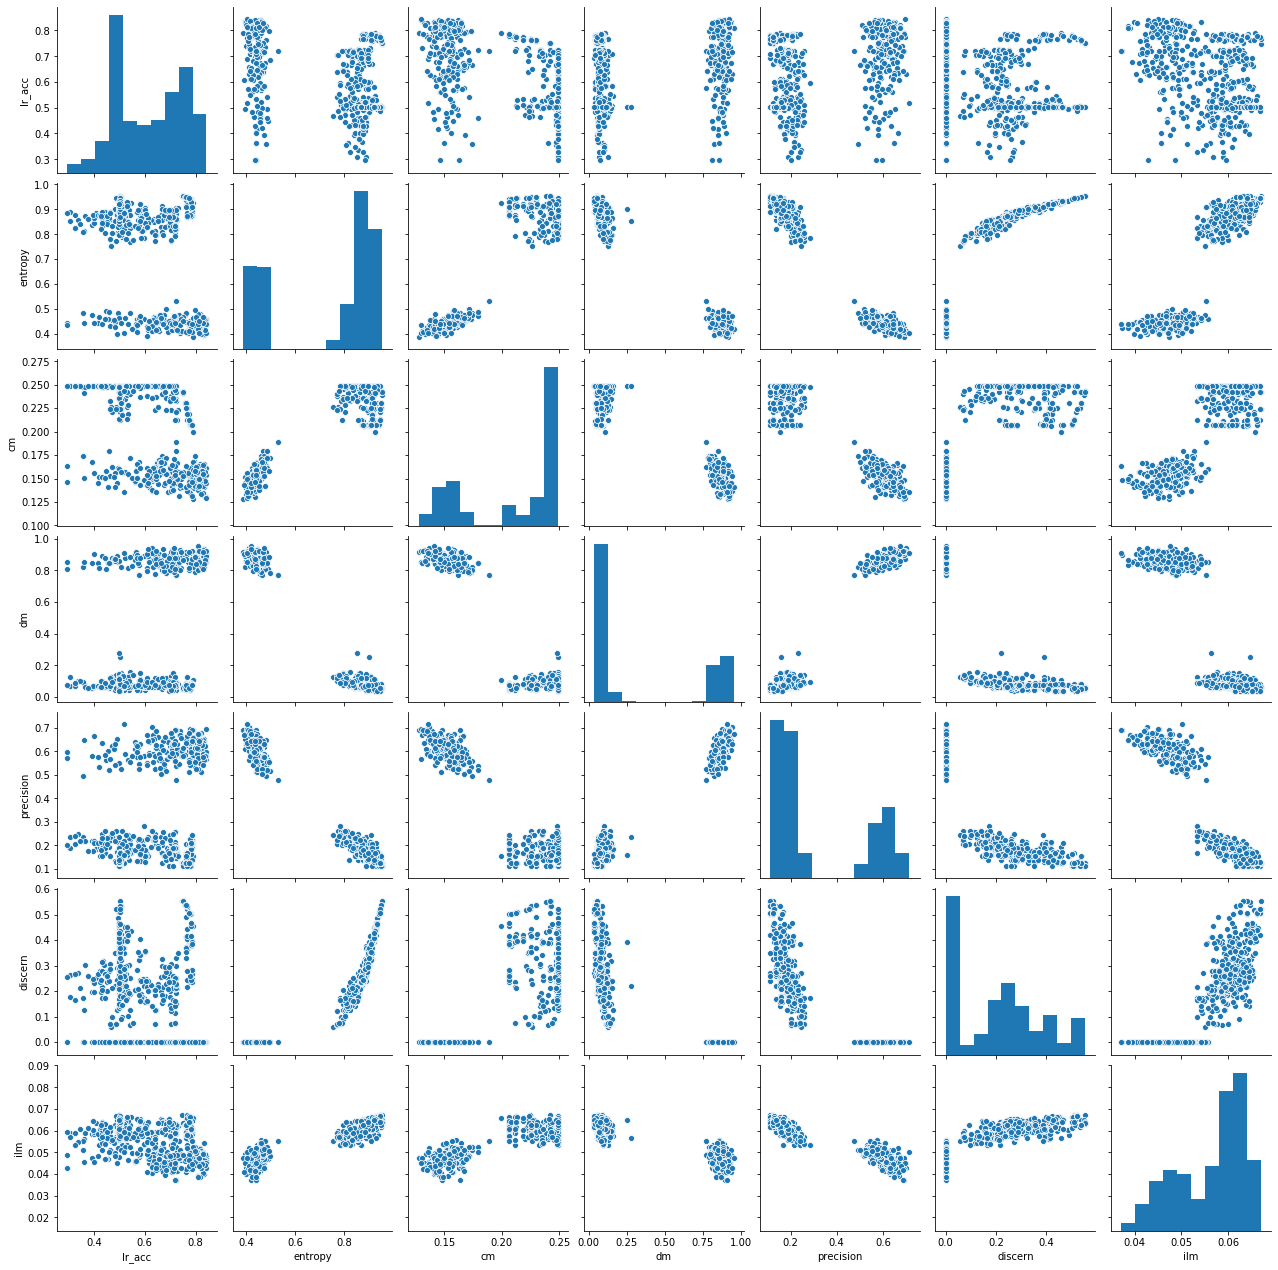

In [4]:
sb.pairplot(results[["lr_acc", "entropy", "cm", "dm", "precision", "discern", "ilm"]])

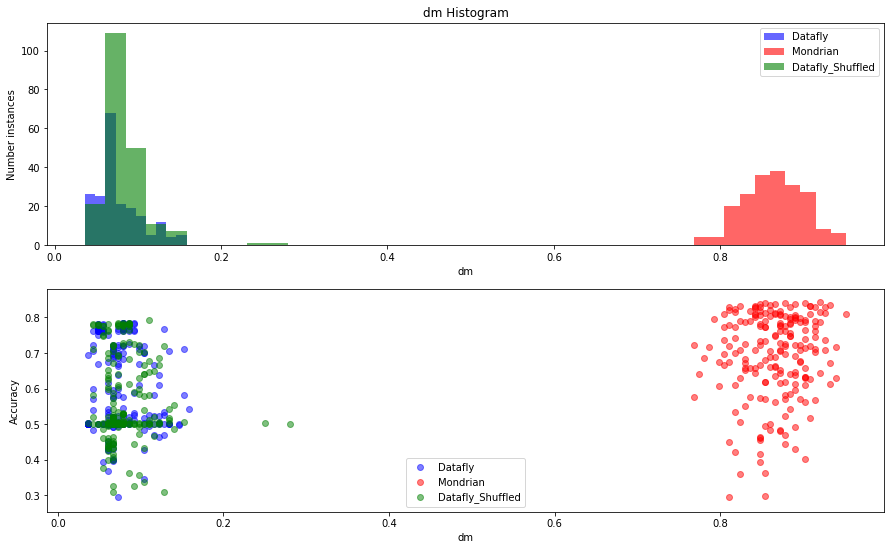

In [5]:
def plot_metric(metric):    
    fig, (ax1, ax2)= plt.subplots(2,1, figsize=(15,9))
    dataflys = results[results["algo"] == "datafly"]
    dataflys_shuff = results[results["algo"] == "datafly_shuffled"]
    mondrians = results[results["algo"] == "mondrian"]
    
    ax1.hist(dataflys[metric], label="Datafly", color="b", alpha=.6)
    ax1.hist(mondrians[metric], label="Mondrian", color="r", alpha=.6)
    ax1.hist(dataflys_shuff[metric], label="Datafly_Shuffled", color="g", alpha=.6)
    ax1.set_xlabel(metric)
    ax1.set_ylabel("Number instances")
    ax1.legend()
    ax1.set_title(f"{metric} Histogram")
    
    ax2.scatter(dataflys[metric], dataflys["lr_acc"], c="b", alpha=0.5, label="Datafly")
    ax2.scatter(mondrians[metric], mondrians["lr_acc"], c="r", alpha=0.5, label="Mondrian")
    ax2.scatter(dataflys_shuff[metric], dataflys_shuff["lr_acc"], c="g", alpha=0.5, label="Datafly_Shuffled")
    ax2.set_xlabel(metric)
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    
plot_metric("dm")

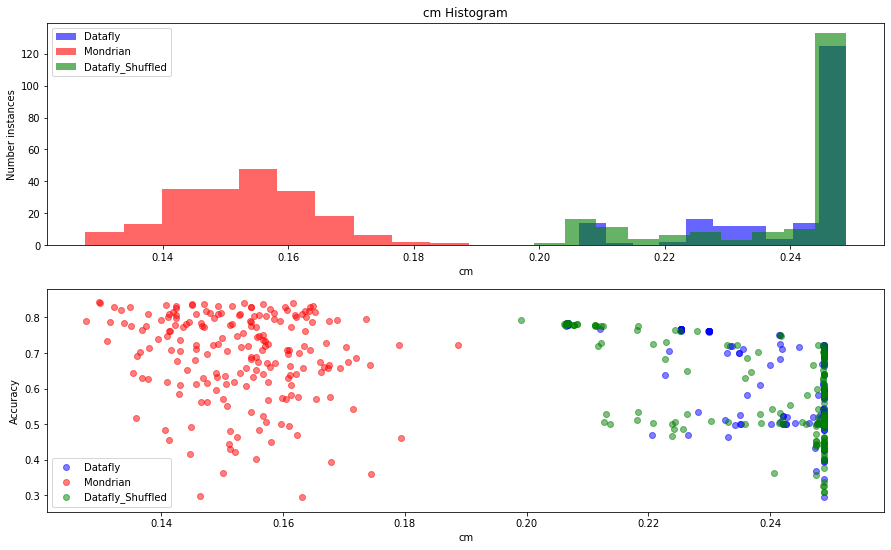

In [6]:
plot_metric("cm")

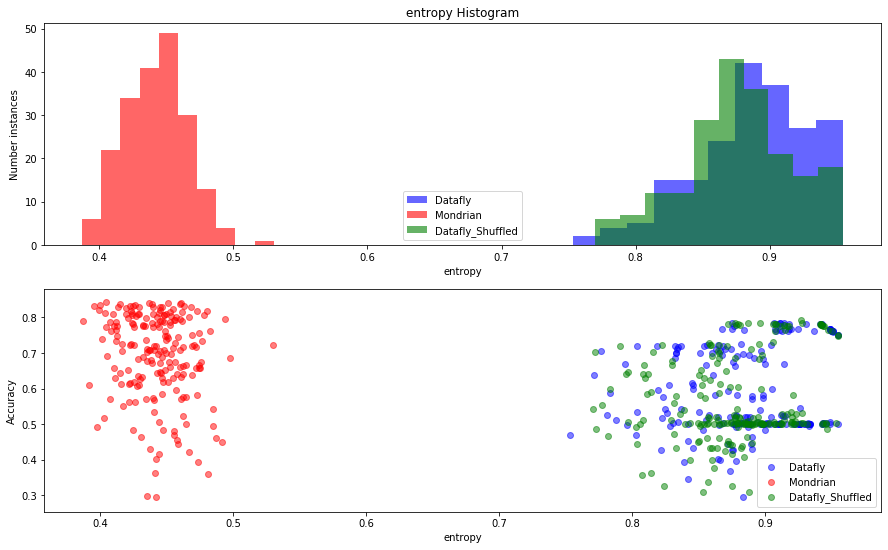

In [7]:
plot_metric("entropy")

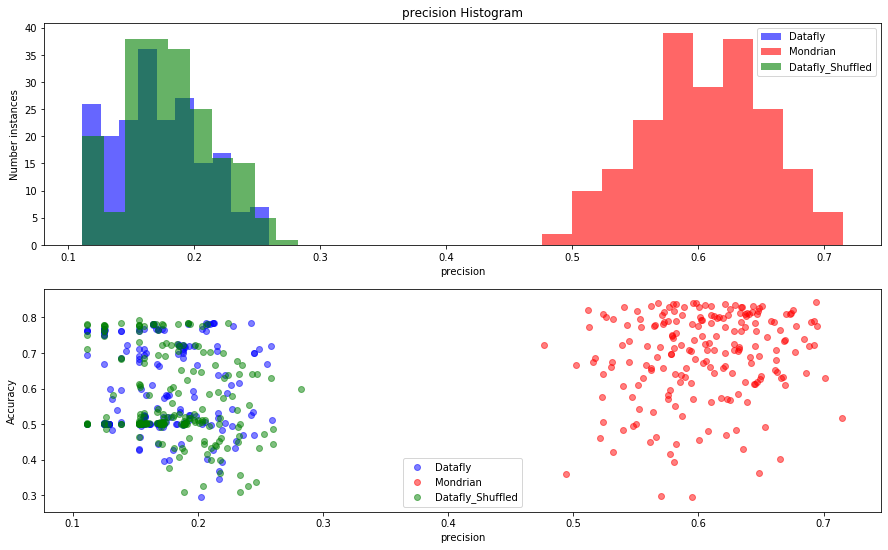

In [8]:
plot_metric("precision")

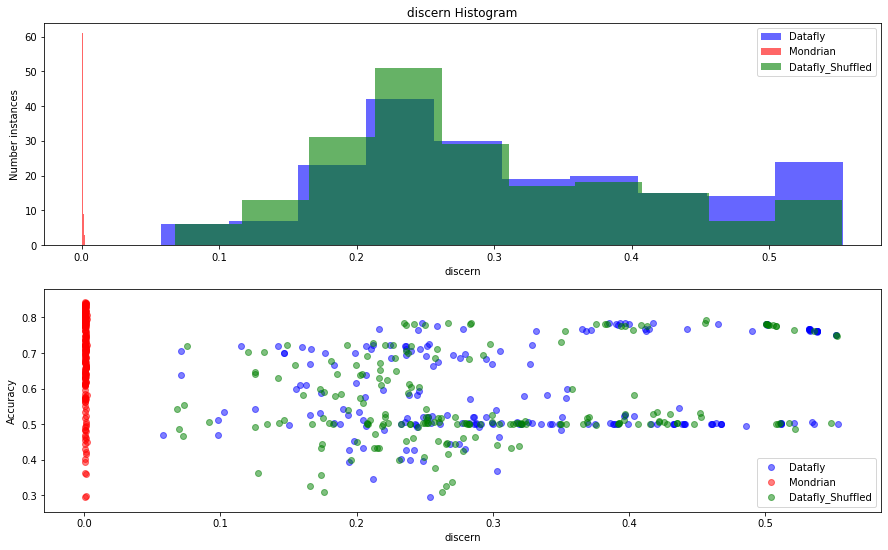

In [9]:
plot_metric("discern")

In [10]:
mondr["discern"].value_counts()

0.000870    1
0.000513    1
0.000775    1
0.000633    1
0.000400    1
           ..
0.000609    1
0.000675    1
0.000616    1
0.001090    1
0.001135    1
Name: discern, Length: 200, dtype: int64

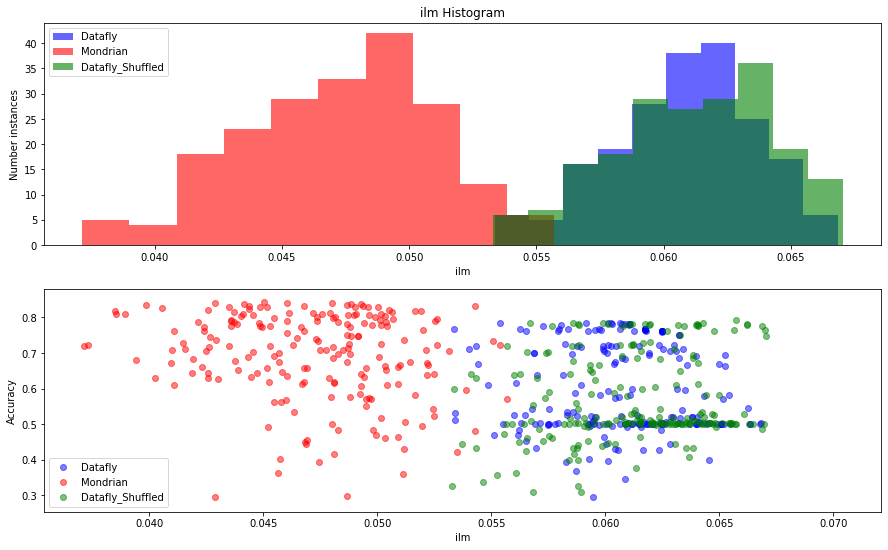

In [11]:
plot_metric("ilm")

# Plot AUROC

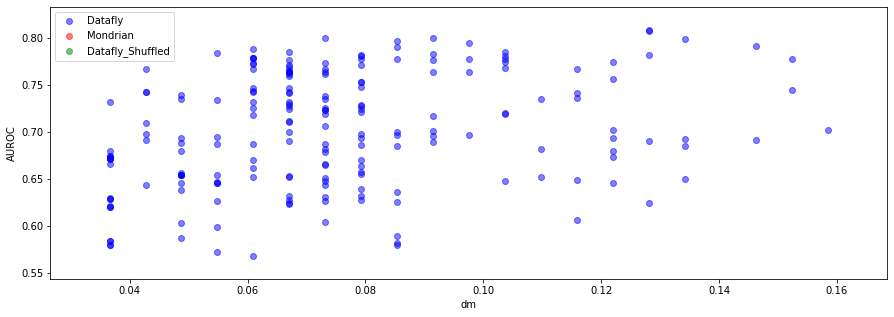

In [12]:
def plot_metric_auroc(metric):    
    fig, (ax2)= plt.subplots(1,1, figsize=(15,5))
    dataflys = results[results["algo"] == "datafly"]
    dataflys_shuff = results[results["algo"] == "datafly_shuffled"]
    mondrians = results[results["algo"] == "mondrian"]

    ax2.scatter(dataflys[metric], dataflys["auroc"], c="b", alpha=0.5, label="Datafly")
    ax2.scatter(mondrians[metric], mondrians["auroc"], c="r", alpha=0.5, label="Mondrian")
    ax2.scatter(dataflys_shuff[metric], dataflys_shuff["auroc"], c="g", alpha=0.5, label="Datafly_Shuffled")
    ax2.set_xlabel(metric)
    ax2.set_ylabel("AUROC")
    ax2.legend()
    
plot_metric_auroc("dm")

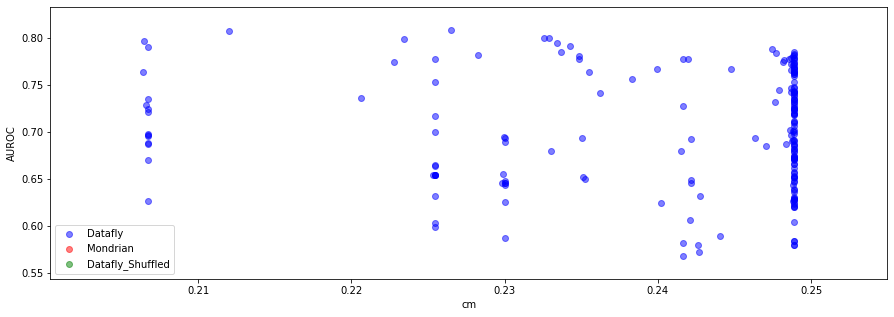

In [13]:
plot_metric_auroc("cm")

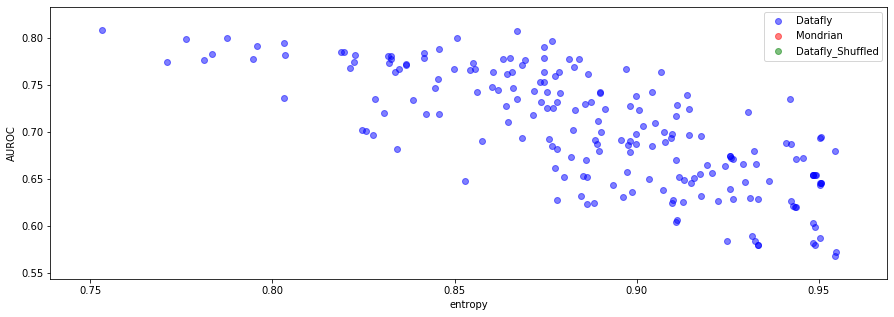

In [14]:
plot_metric_auroc("entropy")

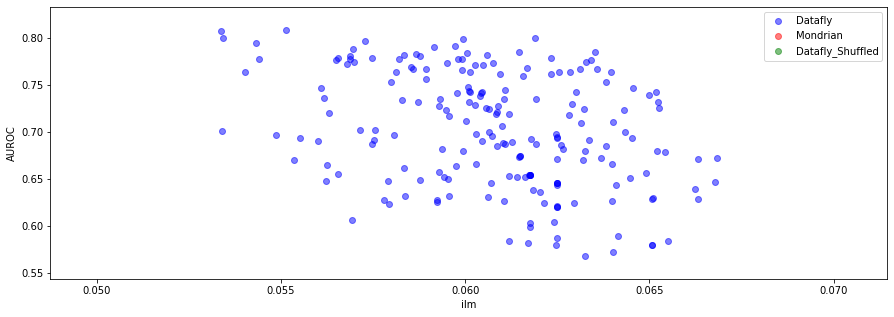

In [15]:
plot_metric_auroc("ilm")

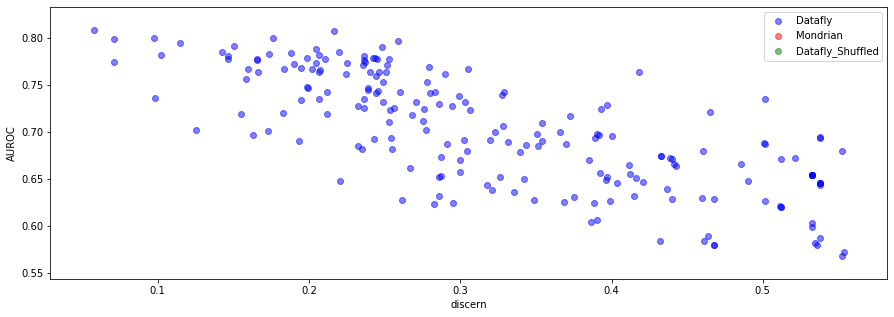

In [16]:
plot_metric_auroc("discern")

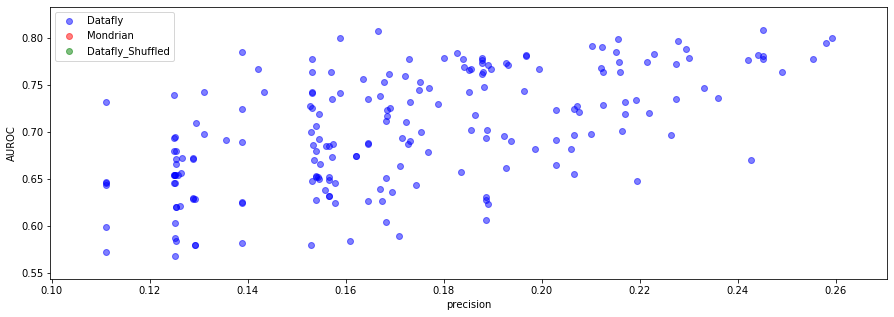

In [17]:
plot_metric_auroc("precision")

# Predicting Power

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def regress(regressor, algo_data):

    X = algo_data[regressor]
    y = algo_data["lr_acc"]

    reg = LinearRegression()
    reg.fit(X, y)

    score = reg.score(X,y)
    return reg, score

def mse(reg, attributes):
    attrs = np.array(results[attributes])
    attrs = attrs.reshape(-1,1) if len(attrs) == 1 else attrs
    y_pred = reg.predict(attrs)
    y_true = results["lr_acc"]
    mse = mean_squared_error(y_true, y_pred)
    return mse

mses = []

In [19]:
def fit_and_graph(regressor, algo_data):
    print(f"Regression on {algo_data['algo'].iloc[0]}")
    reg, score = regress([regressor], algo_data)
    coeff = reg.coef_
    intercept = reg.intercept_
    
    err = mse(reg, [regressor])
    print(f"p-value: {scipy.stats.pearsonr(algo_data[regressor],algo_data['lr_acc'])[1]}")
    print(f"R2 Score: {score}")
    print(f"MSE: {err}")
    print(f"Coeffs: {coeff}")
    print(f"Intercept: {intercept}")
    
    x = np.linspace(0,1,100)
    l = coeff*x + intercept
    
    algo_data.plot.scatter(regressor, "lr_acc", figsize=(15,6), grid=True, 
                           title=f"Linear regression of the {regressor}({algo_data['algo'].iloc[0]})")
            
    plt.plot(x,l)
    


### Entropy

Regression on datafly
p-value: 0.007378721983873298
R2 Score: 0.03569326288526109
MSE: 0.052265618728798535
Coeffs: [0.53371788]
Intercept: 0.12164282049516445

Regression on mondrian
p-value: 0.018526606828008194
R2 Score: 0.027688465098101078
MSE: 0.06970149775460549
Coeffs: [-0.89081417]
Intercept: 1.0865787893458436

Regression on datafly_shuffled
p-value: 0.0026610462654799117
R2 Score: 0.04467417882597725
MSE: 0.06693662088613386
Coeffs: [0.62240743]
Intercept: 0.022191400863196264


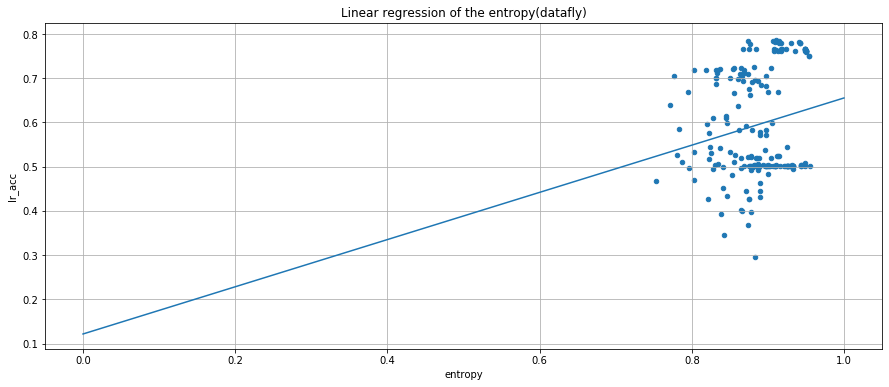

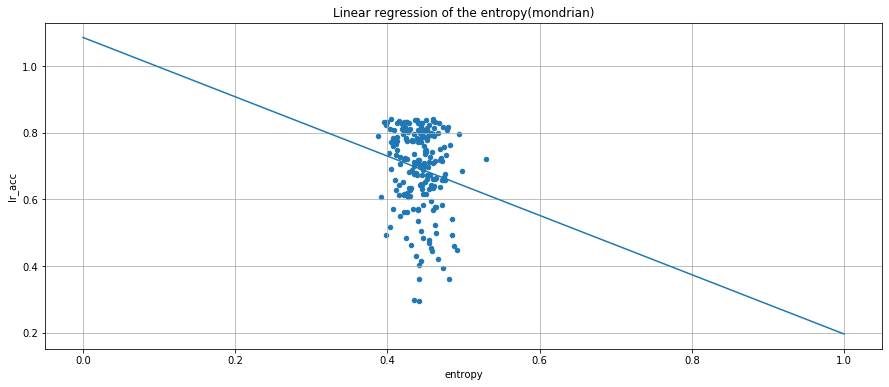

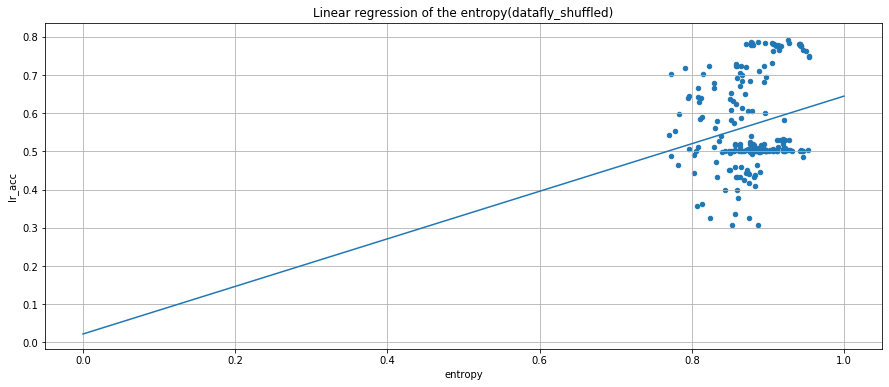

In [20]:
fit_and_graph("entropy", dataf)
print()
fit_and_graph("entropy", mondr)
print()
fit_and_graph("entropy", dataf_shuff)

### Classification Metric

Regression on datafly
p-value: 1.805660686041702e-26
R2 Score: 0.4366584570953985
MSE: 0.0846585618759234
Coeffs: [-6.42244157]
Intercept: 2.1420156519187152

Regression on mondrian
p-value: 0.016317123743348476
R2 Score: 0.028784291252178407
MSE: 0.014940216902362557
Coeffs: [-1.94659965]
Intercept: 0.9900797558858164

Regression on datafly_shuffled
p-value: 2.3997740011373443e-25
R2 Score: 0.42184191889415645
MSE: 0.05029283413799745
Coeffs: [-5.37142624]
Intercept: 1.855197213853371


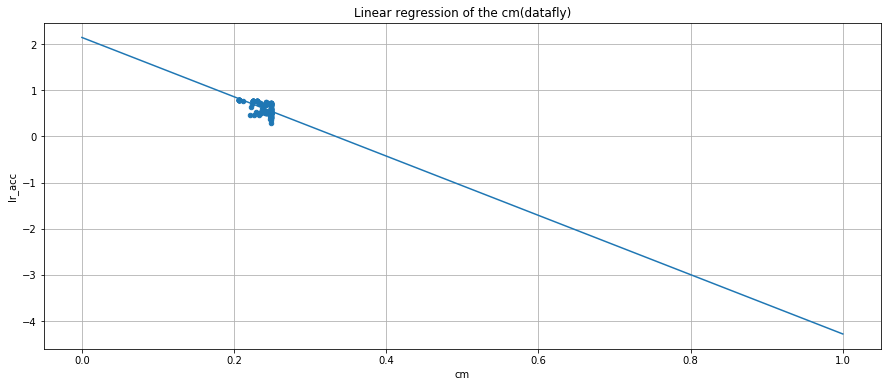

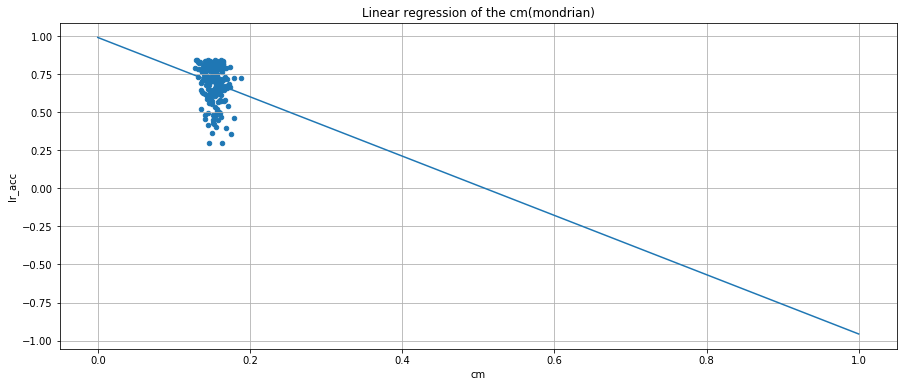

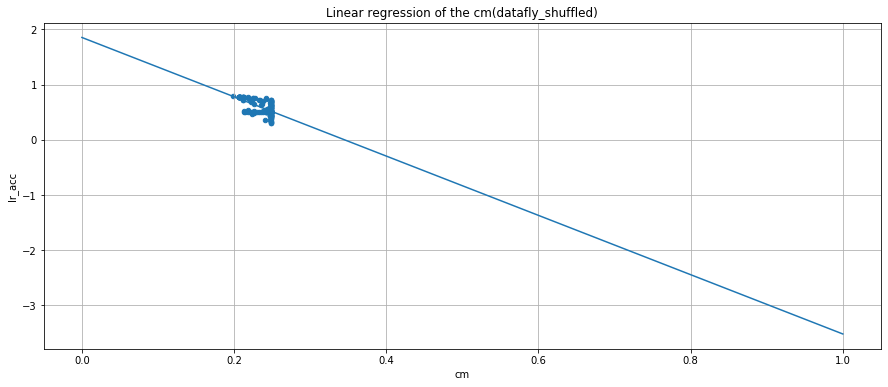

In [21]:
fit_and_graph("cm", dataf)
print()
fit_and_graph("cm", mondr)
print()
fit_and_graph("cm", dataf_shuff)

### DM

Regression on datafly
p-value: 0.5300852430509715
R2 Score: 0.001994093756417459
MSE: 0.036727384931327905
Coeffs: [-0.19838458]
Intercept: 0.6102774490181393

Regression on mondrian
p-value: 0.11193015718282633
R2 Score: 0.012712132343800198
MSE: 0.03736585974687188
Coeffs: [0.37241502]
Intercept: 0.3700852748243817

Regression on datafly_shuffled
p-value: 0.2623015572670993
R2 Score: 0.0063421482358816395
MSE: 0.06554304865682438
Coeffs: [-0.33584597]
Intercept: 0.594910452344894


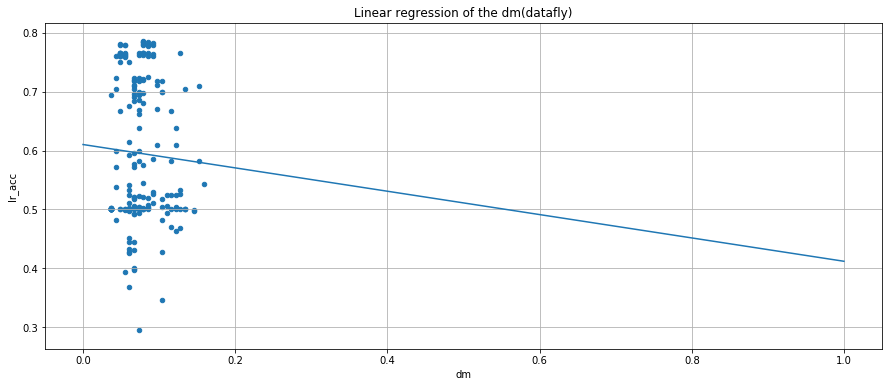

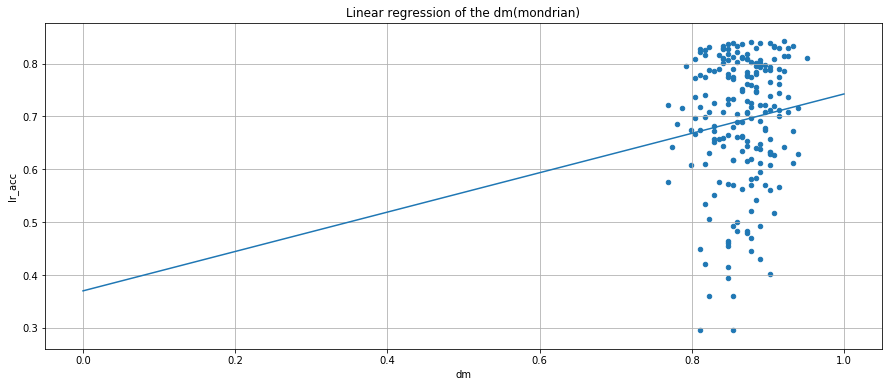

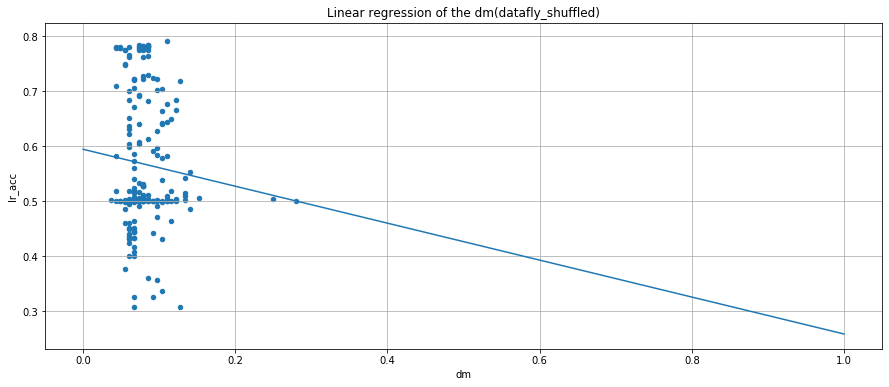

In [22]:
fit_and_graph("dm", dataf)
print()
fit_and_graph("dm", mondr)
print()
fit_and_graph("dm", dataf_shuff)

### Precision


Regression on datafly
p-value: 0.42480650028451783
R2 Score: 0.003220007322617402
MSE: 0.026170211229858655
Coeffs: [-0.19513926]
Intercept: 0.6288937056931493

Regression on mondrian
p-value: 0.025750275311834072
R2 Score: 0.024863738794155266
MSE: 0.018265851369468792
Coeffs: [0.40927918]
Intercept: 0.44500872115339896

Regression on datafly_shuffled
p-value: 0.00016450916657156713
R2 Score: 0.06936616323895828
MSE: 0.10463531497247798
Coeffs: [-0.92112607]
Intercept: 0.7340038643787202


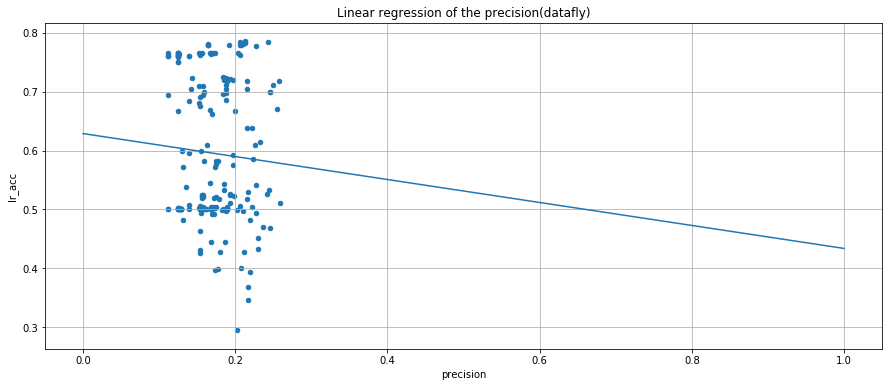

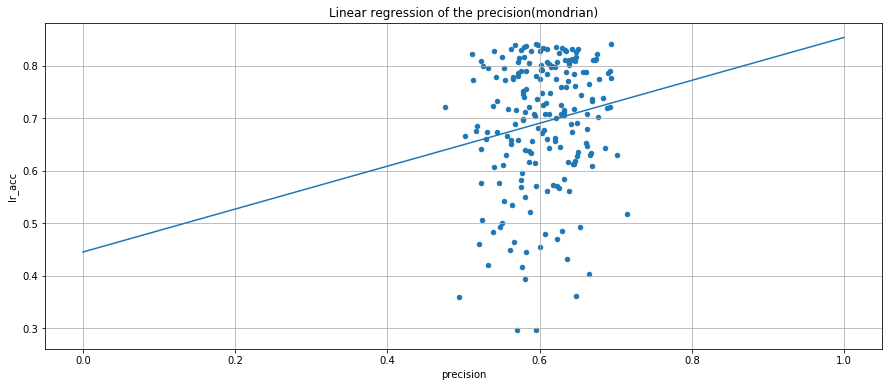

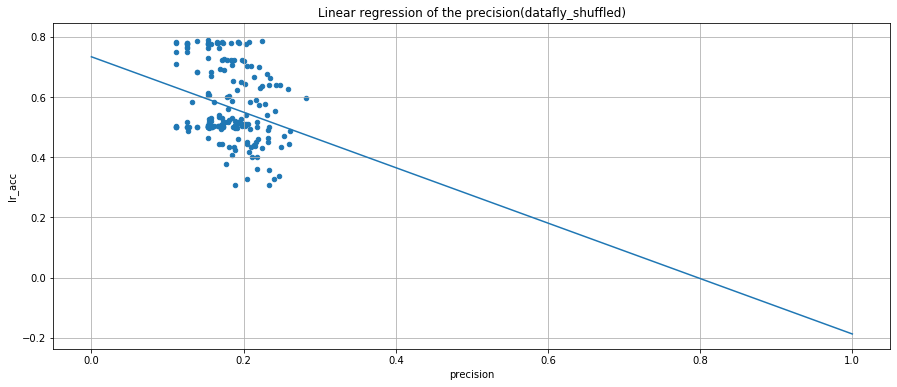

In [23]:
fit_and_graph("precision", dataf)
print()
fit_and_graph("precision", mondr)
print()
fit_and_graph("precision", dataf_shuff)


### Discernability

Regression on datafly
p-value: 0.002932736653803473
R2 Score: 0.04381487105434267
MSE: 0.02352098778964472
Coeffs: [0.20678698]
Intercept: 0.528897863857295

Regression on mondrian
p-value: 0.1878616821202588
R2 Score: 0.008742818371337502
MSE: 98.83120618239745
Coeffs: [-37.57933363]
Intercept: 0.7231862331360334

Regression on datafly_shuffled
p-value: 0.0007751555602763174
R2 Score: 0.05560738096413287
MSE: 0.02768054256190999
Coeffs: [0.25507764]
Intercept: 0.4941690174117322


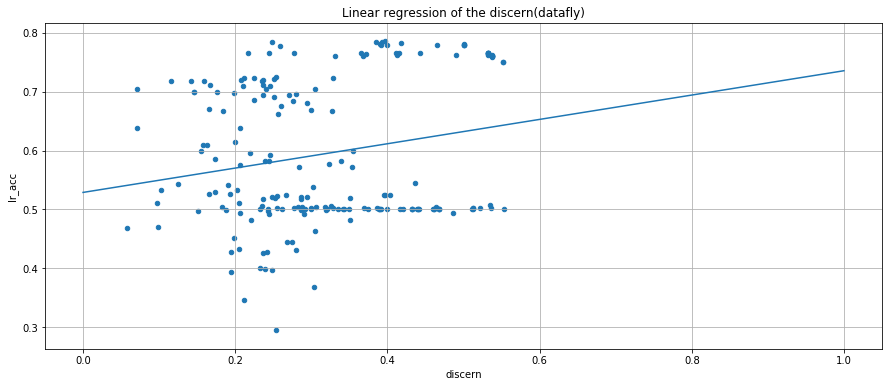

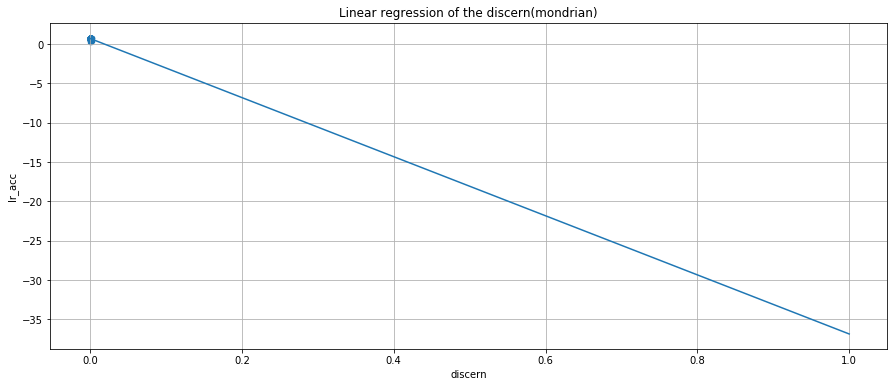

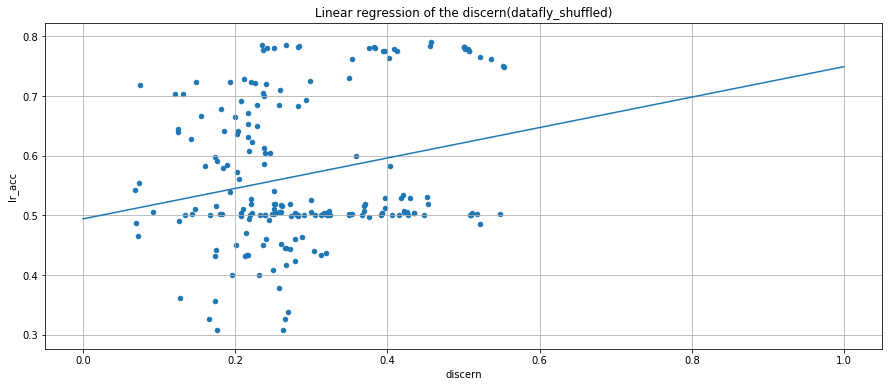

In [24]:
fit_and_graph("discern", dataf)
print()
fit_and_graph("discern", mondr)
print()
fit_and_graph("discern", dataf_shuff)

### Information Loss Metric

Regression on datafly
p-value: 0.1688693933890917
R2 Score: 0.0095387295581012
MSE: 0.015793969375975592
Coeffs: [-4.17193419]
Intercept: 0.8488330462605598

Regression on mondrian
p-value: 0.009028949697088152
R2 Score: 0.033927655673298474
MSE: 0.01576511506300825
Coeffs: [-6.10664854]
Intercept: 0.980952258775841

Regression on datafly_shuffled
p-value: 0.011690290186874269
R2 Score: 0.03167573406703239
MSE: 0.03208522329900391
Coeffs: [6.8433564]
Intercept: 0.14932347127043466


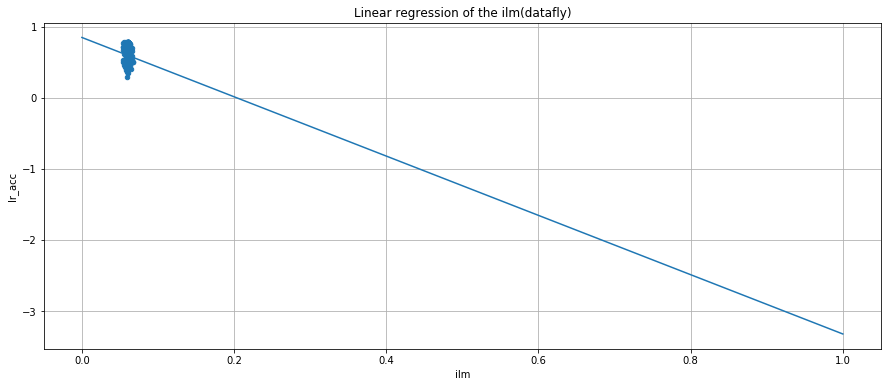

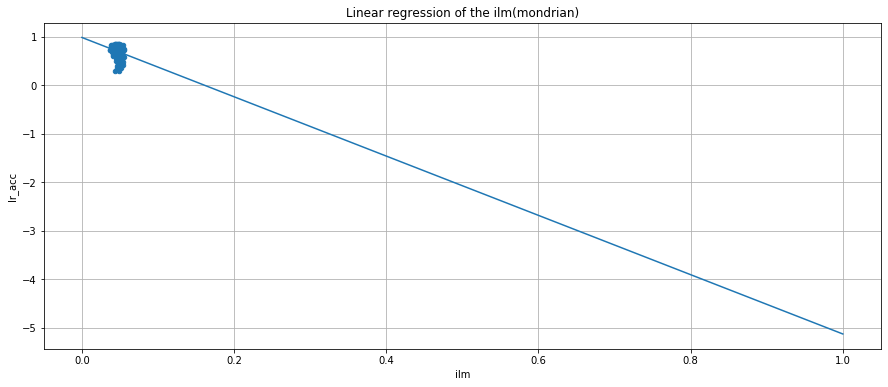

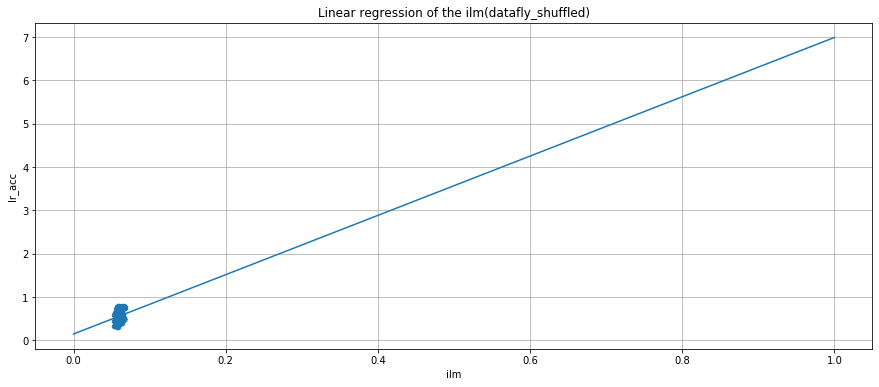

In [25]:
fit_and_graph("ilm", dataf)
print()
fit_and_graph("ilm", mondr)
print()
fit_and_graph("ilm", dataf_shuff)

### Multiple Metrics

In [27]:
metrics = ["entropy", "cm", "dm", "precision", "discern", "ilm"]

res = []
for i in range(1,6):
    
    for comb in itertools.combinations(metrics, i):
        
        ms = list(comb)
        for alg in [mondr, dataf_shuff, dataf]:
            name = alg["algo"].iloc[0] 
            reg, score = regress(ms, alg)
            err = mse(reg, ms)
            p_val = scipy.stats.pearsonr(alg[ms[0]], alg['lr_acc'])[1] if i == 1 else None
            res.append((str(ms), name, p_val, score, err))

            
df = pd.DataFrame(res, columns=["metrics", "algo", "p_value", "R2_score", "MSE_error"])
df = df.set_index(["metrics", "algo"])
df.head(20)

p_value  R2_score  MSE_error
metrics           algo                                               
['entropy']       mondrian          1.852661e-02  0.027688   0.069701
                  datafly_shuffled  2.661046e-03  0.044674   0.066937
                  datafly           7.378722e-03  0.035693   0.052266
['cm']            mondrian          1.631712e-02  0.028784   0.014940
                  datafly_shuffled  2.399774e-25  0.421842   0.050293
                  datafly           1.805661e-26  0.436658   0.084659
['dm']            mondrian          1.119302e-01  0.012712   0.037366
                  datafly_shuffled  2.623016e-01  0.006342   0.065543
                  datafly           5.300852e-01  0.001994   0.036727
['precision']     mondrian          2.575028e-02  0.024864   0.018266
                  datafly_shuffled  1.645092e-04  0.069366   0.104635
                  datafly           4.248065e-01  0.003220   0.026170
['discern']       mondrian          1.878617e-01  0.008743  98.831206
                  datafly_shuffled  7.751556e-04  0.055607   0.027681
                  datafly           2.932737e-03  0.043815   0.023521
['ilm']           mondrian          9.028950e-03  0.033928   0.015765
                  datafly_shuffled  1.169029e-02  0.031676   0.032085
                  datafly           1.688694e-01  0.009539   0.015794
['entropy', 'cm'] mondrian                   NaN  0.033136   0.044308
                  datafly_shuffled           NaN  0.423602   0.068185